## Outlier detection benchmark

Tutorial for benchmarking Robust Iterative trimming GP that detects outliers. It is benchmarked against standard GP and Student-t GP. Here, we compare on neal dataset.
The idea is adapted from https://www.sciencedirect.com/science/article/pii/S2213133721000378?via%3Dihub. Their code is available at https://github.com/syrte/robustgp/

## Imports

In [21]:
from bofire.data_models.surrogates.api import SingleTaskGPSurrogate
from typing import Annotated, Literal
import os
from pydantic import Extra, Field
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from bofire.data_models.domain.api import Inputs, Outputs
from bofire.data_models.features.api import (
    ContinuousInput,
    ContinuousOutput,
)
from bofire.data_models.outlier_detection.api import IterativeTrimming
import bofire.outlier_detection.api as outlier_mapper
import bofire.surrogates.api as surrogate_mapper
from bofire.data_models.kernels.api import (
    RBFKernel,
    ScaleKernel,
    MaternKernel,
    AnyKernel,
)
from bofire.data_models.priors.api import (
    BOTORCH_LENGTHCALE_PRIOR,
    BOTORCH_NOISE_PRIOR,
    BOTORCH_SCALE_PRIOR,
    AnyPrior,
)
from bofire.data_models.surrogates.api import (
    ScalerEnum,
    SingleTaskGPSurrogate,
)
from bofire.data_models.surrogates.botorch import BotorchSurrogate
from scipy.stats import t, norm, uniform
import base64
import io
from typing import Dict, Optional

import botorch
import dill
import gpytorch
import numpy as np
import pandas as pd
import torch
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from gpytorch.likelihoods import StudentTLikelihood
from gpytorch.mlls import VariationalELBO

import bofire.kernels.api as kernels
import bofire.priors.api as priors
from bofire.data_models.enum import OutputFilteringEnum
from bofire.surrogates.botorch import BotorchSurrogate as BotorchSurrogate1
from bofire.surrogates.single_task_gp import get_scaler
from bofire.surrogates.trainable import TrainableSurrogate
from bofire.utils.torch_tools import tkwargs

SMOKE_TEST = os.environ.get("SMOKE_TEST")


## Class for Student-t GP 

In [22]:
class DataModel(BotorchSurrogate):
    class Config:
        arbitrary_types_allowed = True
        extra = Extra.allow

    type: Literal[
        "SingleTaskVariationalGPSurrogate"
    ] = "SingleTaskVariationalGPSurrogate"
    num_outputs: Annotated[int, Field(ge=1)] = 1
    kernel: AnyKernel = Field(
        default_factory=lambda: ScaleKernel(
            base_kernel=MaternKernel(
                ard=True,
                nu=2.5,
                lengthscale_prior=BOTORCH_LENGTHCALE_PRIOR(),
            ),
            outputscale_prior=BOTORCH_SCALE_PRIOR(),
        )
    )
    noise_prior: AnyPrior = Field(default_factory=lambda: BOTORCH_NOISE_PRIOR())
    scaler: ScalerEnum = ScalerEnum.NORMALIZE

    @classmethod
    def is_output_implemented(cls, my_type) -> bool:
        """Abstract method to check output type for surrogate models
        Args:
            my_type: continuous or categorical output
        Returns:
            bool: True if the output type is valid for the surrogate chosen, False otherwise
        """
        return isinstance(my_type, type(ContinuousOutput))


class SingleTaskVariationalGPSurrogate(BotorchSurrogate1, TrainableSurrogate):
    def __init__(
        self,
        data_model: DataModel,
        **kwargs,
    ):
        self.kernel = data_model.kernel
        self.scaler = data_model.scaler
        self.noise_prior = data_model.noise_prior
        self.num_outputs = data_model.num_outputs
        super().__init__(data_model=data_model, **kwargs)

    model: Optional[botorch.models.SingleTaskVariationalGP] = None
    _output_filtering: OutputFilteringEnum = OutputFilteringEnum.ALL
    training_specs: Dict = {}

    def _fit(self, X: pd.DataFrame, Y: pd.DataFrame):
        scaler = get_scaler(self.inputs, self.input_preprocessing_specs, self.scaler, X)
        transformed_X = self.inputs.transform(X, self.input_preprocessing_specs)

        tX, tY = torch.from_numpy(transformed_X.values).to(**tkwargs), torch.from_numpy(
            Y.values
        ).to(**tkwargs)
        self.output_transform = Standardize(m=tY.shape[-1])
        tY, _ = self.output_transform(tY)
        self.model = botorch.models.SingleTaskVariationalGP(  # type: ignore
            train_X=tX,
            train_Y=tY,
            likelihood=StudentTLikelihood(noise_prior=priors.map(self.noise_prior)),
            num_outputs=self.num_outputs,
            learn_inducing_points=False,
            inducing_points=tX,
            covar_module=kernels.map(
                self.kernel,
                batch_shape=torch.Size(),
                active_dims=list(range(tX.shape[1])),
                ard_num_dims=1,  # this keyword is ingored
            ),
            # outcome_transform=Standardize(m=tY.shape[-1]),
            input_transform=scaler,
        )

        # self.model.likelihood.noise_covar.noise_prior = priors.map(self.noise_prior)  # type: ignore

        mll = VariationalELBO(
            self.model.likelihood, self.model.model, num_data=tX.shape[-2]
        )
        fit_gpytorch_mll(mll, options=self.training_specs, max_attempts=10)

    def _predict(self, transformed_X: pd.DataFrame):
        # transform to tensor
        X = torch.from_numpy(transformed_X.values).to(**tkwargs)
        self.model.model.eval()  # type: ignore
        self.model.likelihood.eval()  # type: ignore
        with torch.no_grad() and gpytorch.settings.num_likelihood_samples(128):
            preds = self.model.posterior(X=X, observation_noise=True).mean.mean(dim=0).cpu().detach()  # type: ignore
            variance = self.model.posterior(X=X, observation_noise=True).variance.mean(dim=0).cpu().detach()  # type: ignore

            preds, variance = self.output_transform.untransform(preds, variance)
            preds = preds.numpy()
            stds = np.sqrt(variance.numpy())  # type: ignore
        return preds, stds

    def _dumps(self) -> str:
        """Dumps the actual model to a string via pickle as this is not directly json serializable."""
        buffer = io.BytesIO()
        torch.save(
            {"model": self.model, "output_transform": self.output_transform},
            buffer,
            pickle_module=dill,
        )
        return base64.b64encode(buffer.getvalue()).decode()

    def loads(self, data: str):
        """Loads the actual model from a base64 encoded pickle bytes object and writes it to the `model` attribute."""
        buffer = io.BytesIO(base64.b64decode(data.encode()))
        path = torch.load(buffer, pickle_module=dill)
        self.model = path["model"]
        self.output_transform = path["output_transform"]

## set up inputs, outputs and surrogate models for different GPs

In [23]:
inputs = Inputs(
    features=[
        ContinuousInput(
            key=f"x_{1}",
            bounds=(-3, 3),
        ),
    ]
)
outputs = Outputs(features=[ContinuousOutput(key="y")])

In [24]:
kernel = ScaleKernel(base_kernel=RBFKernel(ard=True))
scaler = ScalerEnum.NORMALIZE

In [25]:
model_GP = SingleTaskGPSurrogate(
    inputs=inputs, outputs=outputs, kernel=kernel, scaler=scaler
)
model_GP = surrogate_mapper.map(model_GP)
model_tP = DataModel(inputs=inputs, outputs=outputs, kernel=kernel, scaler=scaler)
model_tP = SingleTaskVariationalGPSurrogate(data_model=model_tP)
model_ideal_GP = SingleTaskGPSurrogate(
    inputs=inputs, outputs=outputs, kernel=kernel, scaler=scaler
)
model_ideal_GP = surrogate_mapper.map(model_ideal_GP)
model_ITGP = SingleTaskGPSurrogate(
    inputs=inputs, outputs=outputs, kernel=kernel, scaler=scaler
)
model_ITGP_final = SingleTaskGPSurrogate(
    inputs=inputs, outputs=outputs, kernel=kernel, scaler=scaler
)
model_ITGP_final = surrogate_mapper.map(model_ITGP_final)

In [26]:
ITGP_detector = IterativeTrimming(base_gp=model_ITGP)
ITGP_detector = outlier_mapper.map(ITGP_detector)


## Neal dataset
We create neal dataset for benchmarking from the paper  https://www.sciencedirect.com/science/article/pii/S2213133721000378?via%3Dihub.

In [27]:
def neal_func(x):
    return 0.3 + 0.4 * x + 0.5 * np.sin(2.7 * x) + 1.1 / (1 + x**2)


def neal_dataset(
    n=100, s1=0.1, s2=1, m2=0, f2=0.15, t2="n", sampling="rand", **args_extra
):
    n2 = int(n * f2)
    n1 = n - n2

    if sampling == "randn":
        x = np.random.randn(n)
    elif sampling == "rand":
        x = np.random.rand(n) * 6 - 3
    elif sampling == "grid":
        x = np.linspace(-3, 3, n)
    else:
        raise ValueError
    y_tr = neal_func(x)

    y_ob = np.zeros(n)
    label = np.zeros(n, dtype=int)

    ix1 = np.zeros(n, dtype=bool)
    ix1[np.random.choice(n, n1, replace=False)] = True
    ix2 = ~ix1

    y_ob[ix1] = y_tr[ix1] + norm(0, s1).rvs(n1)
    if t2 == "n":
        y_ob[ix2] = y_tr[ix2] + norm(m2, s2).rvs(n2)
    elif t2 == "t1":
        y_ob[ix2] = y_tr[ix2] + t(1, m2, s2).rvs(n2)
    elif t2 == "t3":
        y_ob[ix2] = y_tr[ix2] + t(3, m2, s2).rvs(n2)
    elif t2 == "u":
        y_ob[ix2] = uniform(m2, s2).rvs(n2)
    else:
        raise ValueError

    label[ix1] = 0
    label[ix2] = 1

    dic = dict(x=x, y_ob=y_ob, y_tr=y_tr, label=label)
    return dic


# np.random.seed(5)
sample = 10 if not SMOKE_TEST else 1
n = 100

## Adding outliers
We use 9 outlier noise conditions to test our models

In [28]:
args_list = [
    ("zero", dict(n=n, s1=0.1, s2=1.0, m2=0, f2=0, t2="n")),
    ("rare", dict(n=n, s1=0.1, s2=1.0, m2=0, f2=0.05, t2="n")),
    ("fiducial", dict(n=n, s1=0.1, s2=1.0, m2=0, f2=0.15, t2="n")),
    ("abundant", dict(n=n, s1=0.1, s2=1.0, m2=0, f2=0.45, t2="n")),
    ("skewed", dict(n=n, s1=0.1, s2=1.0, m2=2, f2=0.15, t2="n")),
    ("extreme", dict(n=n, s1=0.1, s2=5.0, m2=0, f2=0.15, t2="n")),
    ("uniform", dict(n=n, s1=0.1, s2=6.0, m2=-3, f2=0.3, t2="u")),
    ("t3", dict(n=n, s1=0.1, s2=0.1, m2=0, f2=1, t2="t3")),
    ("t1", dict(n=n, s1=0.1, s2=0.1, m2=0, f2=1, t2="t1")),
]

C:\Users\S31990\AppData\Local\Temp\ipykernel_20244\2875415920.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax[i, j].scatter(


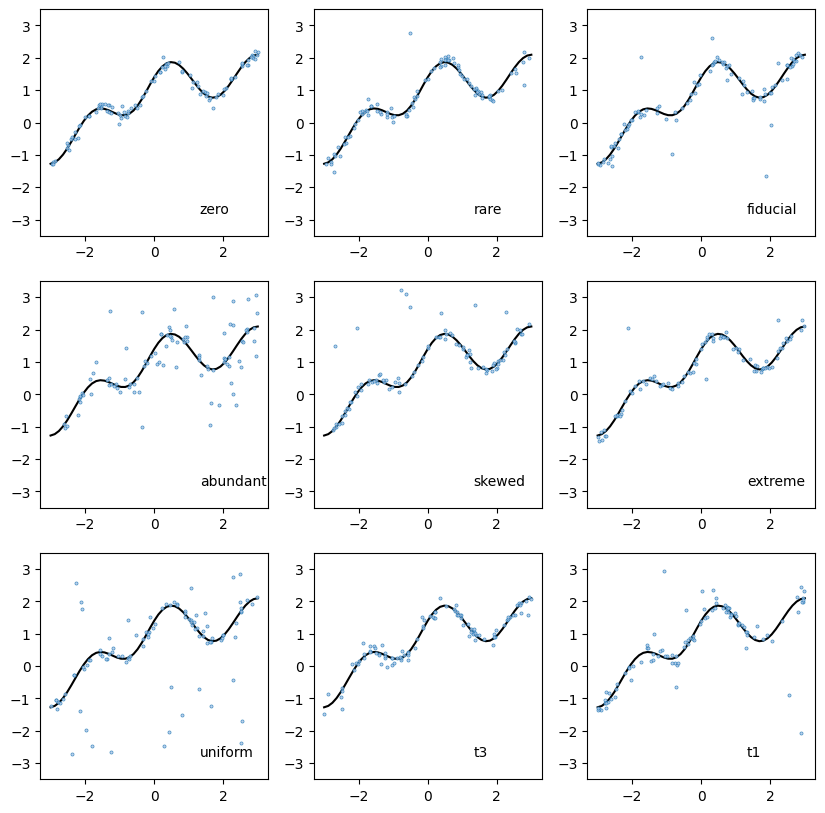

In [29]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
k = 0
for i in range(3):
    for j in range(3):
        d = neal_dataset(**args_list[k][1])
        ax[i, j].scatter(
            d["x"],
            d["y_ob"],
            facecolor=cm.tab20.colors[1],
            edgecolor=cm.tab20.colors[0],
            vmin=-0.5,
            vmax=1.5,
            s=5,
            lw=0.5,
            alpha=0.8,
        )
        x = np.linspace(-3, 3, 51)
        ax[i, j].plot(x, neal_func(x), "k-", lw=1.5, zorder=-1)
        ax[i, j].set_ylim(-3.5, 3.5)
        ax[i, j].text(0.7, 0.1, args_list[k][0], transform=ax[i, j].transAxes)
        k = k + 1

## Run fitting
We use standard GP for dataset without outliers, standard GP for outliers, Iterative gp (ITGP) and student-t GP

In [30]:
def loss_RMSE(y, y0):
    return np.sqrt(np.mean((y - y0) ** 2))


cols = [
    "zero",
    "rare",
    "fiducial",
    "abundant",
    "skewed",
    "extreme",
    "uniform",
    "t3",
    "t1",
]
rmse_GP, rmse_ideal, rmse_ITGP, rmse_tP = (
    pd.DataFrame(columns=cols),
    pd.DataFrame(columns=cols),
    pd.DataFrame(columns=cols),
    pd.DataFrame(columns=cols),
)
test_data = neal_dataset(
    **dict(n=1000, s1=0, s2=0, m2=0, f2=0, sampling="grid", mode="test")
)
test_experiments = pd.DataFrame()
test_experiments["x_1"] = test_data["x"]
test_experiments["y"] = test_data["y_tr"]

for j in range(len(cols)):
    GP, ideal_GP, ITGP, tP = [], [], [], []
    for i in range(sample):
        train_data = neal_dataset(**args_list[j][1])
        experiments = pd.DataFrame()
        experiments["x_1"] = train_data["x"]
        experiments["y"] = train_data["y_ob"]
        experiments["valid_y"] = 1
        ideal_experiments = experiments.copy()
        ideal_experiments.loc[train_data["label"] == 1, "valid_y"] = 0
        experiments_trimmed = ITGP_detector.detect(experiments)
        model_GP.fit(experiments)
        model_tP.fit(experiments)
        GP_test = model_GP.predict(test_experiments)
        tP_test = model_tP.predict(test_experiments)
        if cols[j] != "t3" and cols[j] != "t1":
            model_ideal_GP.fit(ideal_experiments)
            ideal_GP_test = model_ideal_GP.predict(test_experiments)
            ideal_GP.append(
                loss_RMSE(ideal_GP_test["y_pred"], test_experiments["y"])
            )
        else:
            ideal_GP.append(np.NaN)
        model_ITGP_final.fit(experiments_trimmed)
        ITGP_test = model_ITGP_final.predict(test_experiments)

        GP.append(loss_RMSE(GP_test["y_pred"], test_experiments["y"]))

        ITGP.append(loss_RMSE(ITGP_test["y_pred"], test_experiments["y"]))

        tP.append(loss_RMSE(tP_test["y_pred"], test_experiments["y"]))

    rmse_GP[cols[j]] = np.array(GP) / 0.032
    rmse_ideal[cols[j]] = np.array(ideal_GP) / 0.032
    rmse_ITGP[cols[j]] = np.array(ITGP) / 0.032
    rmse_tP[cols[j]] = np.array(tP) / 0.032

c:\Users\S31990\AppData\Local\anaconda3\envs\bofire\lib\site-packages\botorch\models\model.py:212: RuntimeWarning: Could not update `train_inputs` with transformed inputs since SingleTaskVariationalGP does not have a `train_inputs` attribute. Make sure that the `input_transform` is applied to both the train inputs and test inputs.
  warnings.warn(
c:\Users\S31990\AppData\Local\anaconda3\envs\bofire\lib\site-packages\botorch\models\model.py:212: RuntimeWarning: Could not update `train_inputs` with transformed inputs since SingleTaskVariationalGP does not have a `train_inputs` attribute. Make sure that the `input_transform` is applied to both the train inputs and test inputs.
  warnings.warn(
c:\Users\S31990\AppData\Local\anaconda3\envs\bofire\lib\site-packages\botorch\models\model.py:212: RuntimeWarning: Could not update `train_inputs` with transformed inputs since SingleTaskVariationalGP does not have a `train_inputs` attribute. Make sure that the `input_transform` is applied to both t

## Performance comparision
Here we plot the performance comparision similar to fig 4 in paper  https://www.sciencedirect.com/science/article/pii/S2213133721000378?via%3Dihub. ITGP performs better than other GPs

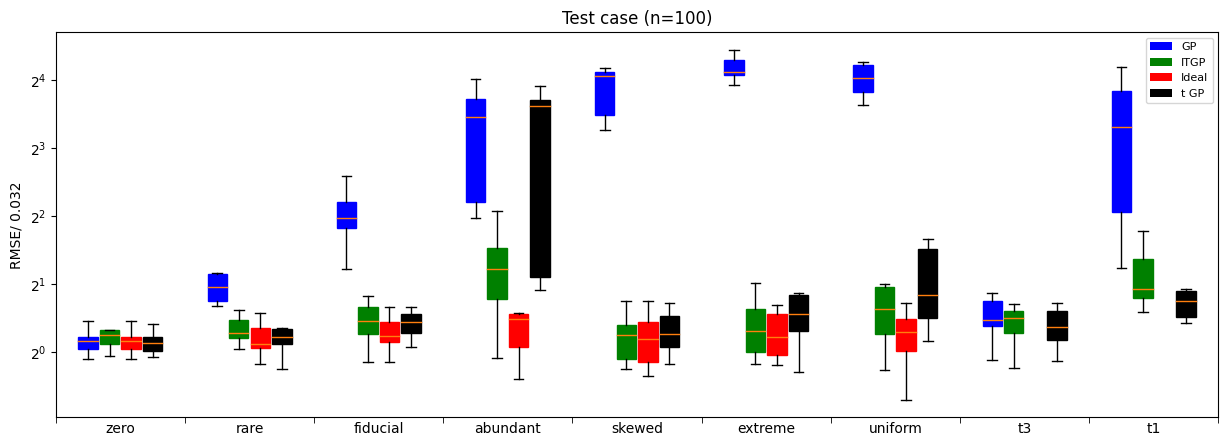

In [31]:
import matplotlib.ticker as ticker
from matplotlib.patches import Patch

# Define the groups
groups = ["GP", "ITGP", "Ideal", "t GP"]

datasets = [rmse_GP, rmse_ITGP, rmse_ideal, rmse_tP]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# Set x-positions for boxes
x_pos_range = np.arange(len(datasets)) / (len(datasets) - 1)
x_pos = (x_pos_range * 0.5) + 0.75
# Plot
colours = ["blue", "green", "red", "black"]
for i, data in enumerate(datasets):
    bp = plt.boxplot(
        np.array(data),
        sym="",  # whis=[0, 100],
        widths=0.6 / len(datasets),
        labels=list(datasets[0]),
        patch_artist=True,
        positions=[x_pos[i] + j * 1 for j in range(len(data.T))],
    )
    k = i % len(colours)
    for box in bp["boxes"]:
        box.set(facecolor=colours[k])
    for element in ["boxes", "fliers", "means"]:
        plt.setp(bp[element], color=colours[k])
# Titles
plt.title("Test case (n=100)")
plt.ylabel("RMSE/ 0.032")
# Axis ticks and labels
plt.xticks(np.arange(len(list(datasets[0]))) + 1)
plt.gca().xaxis.set_minor_locator(
    ticker.FixedLocator(np.array(range(len(list(datasets[0])) + 1)) + 0.5)
)
plt.gca().tick_params(axis="x", which="minor", length=4)
plt.gca().tick_params(axis="x", which="major", length=0)
# Change the limits of the x-axis
plt.xlim([0.5, len(list(datasets[0])) + 0.5])
# plt.ylim(0.25,16)
plt.yscale("log", base=2)
legend_elements = []
for i in range(len(datasets)):
    j = i % len(groups)
    k = i % len(colours)
    legend_elements.append(Patch(facecolor=colours[k], label=groups[j]))
plt.legend(handles=legend_elements, fontsize=8)